# Setup and load data:

In [1]:
%load_ext autoreload
%autoreload 2

from functions.functions import *
from functions.plotting import *
from functions.autoencoder import *
from functions.mdn import *
from keras import backend as K
from keras.callbacks import TerminateOnNaN, ModelCheckpoint
from keras.models import model_from_json
from livelossplot.keras import PlotLossesCallback
import livelossplot
import tensorflow as tf
import numpy as np
import os
import glob
from itertools import combinations
import matplotlib
plt.rcParams['animation.ffmpeg_path'] = '/gpfs/loomis/project/hep/demers/mnp3/conda_envs/choreo/bin/ffmpeg' # for using html5 video in Jupyter notebook
print(matplotlib.animation.writers.list()) # check that ffmpeg is loaded. if it's not there, use .to_jshtml() instead of .to_html5_video().

Using TensorFlow backend.


['ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']


In [2]:
setup_gpus()

GPUs found: 0


()

In [3]:
data = load_data('rnn_data/mariel_*')

Files loaded: ['rnn_data/mariel_betternot_and_retrograde.npy', 'rnn_data/mariel_beyond.npy', 'rnn_data/mariel_chunli.npy', 'rnn_data/mariel_honey.npy', 'rnn_data/mariel_knownbetter.npy', 'rnn_data/mariel_penelope.npy']


# Check out the real data:

In [4]:
frame = np.random.randint(0,data.full.X.shape[1]-50)
print("Starting from frame {}...".format(frame))

HTML(animate(data.full.X[:,frame:,:], frames=100))
# HTML(animate(data.selected.X[:,frame:,:], frames=100, edges=data.selected.edges, colors='black'))

Starting from frame 40817...


# Build the autoencoder for poses

### Define the training dataset:

In [5]:
# X_train = data.selected.X    # 15 joints
X_train = data.full.X[:,:int(data.full.X.shape[1]*.8),:]    # 53 joints (80% train)
X_test = data.full.X[:,int(data.full.X.shape[1]*.8):,:]    # 53 joints (20% test)
print("Training set size: {}".format(X_train.shape))
print("Test set size: {}".format(X_test.shape))

Training set size: (53, 35447, 3)
Test set size: (53, 8862, 3)


### Train without adding random (x,y) offsets:

In [6]:
ae_nooffset = Autoencoder(n_verts=X_train.shape[0], latent_dim=2, n_layers=2, n_units=64, relu=True, dropout=False, add_random_offsets=False)
ae_nooffset.model.summary()
X_T = X_train.transpose((1,0,2))
ae_nooffset.model.fit(X_T, X_T, batch_size = 128, epochs = 50)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 53, 3)             0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 14530     
_________________________________________________________________
model_2 (Model)              (None, 53, 3)             14687     
Total params: 29,217
Trainable params: 29,217
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


/gpfs/loomis/project/hep/demers/mnp3/conda_envs/choreo/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/gpfs/loomis/project/hep/demers/mnp3/conda_envs/choreo/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/gpfs/loomis/project/hep/demers/mnp3/conda_envs/choreo/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/gpfs/loomis/project/hep/demers/mnp3/conda_envs/choreo/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', Deprec

Epoch 1/50
35447/35447 [==============================] - 2s 50us/step - loss: 0.1096
Epoch 2/50
35447/35447 [==============================] - 1s 23us/step - loss: 0.0122
Epoch 3/50
35447/35447 [==============================] - 1s 22us/step - loss: 0.0120
Epoch 4/50
35447/35447 [==============================] - 1s 22us/step - loss: 0.0112
Epoch 5/50
35447/35447 [==============================] - 1s 22us/step - loss: 0.0092
Epoch 6/50
35447/35447 [==============================] - 1s 22us/step - loss: 0.0068
Epoch 7/50
35447/35447 [==============================] - 1s 22us/step - loss: 0.0055
Epoch 8/50
35447/35447 [==============================] - 1s 22us/step - loss: 0.0052
Epoch 9/50
35447/35447 [==============================] - 1s 22us/step - loss: 0.0051
Epoch 10/50
35447/35447 [==============================] - 1s 23us/step - loss: 0.0050
Epoch 11/50
35447/35447 [==============================] - 1s 23us/step - loss: 0.0050
Epoch 12/50
35447/35447 [===========================

### Real data in blue, autoencoded predictions in orange (we want these to be very similar):

In [7]:
n_frames = 100
frame = np.random.randint(0,X_test.shape[1]-n_frames)
print("Seeding with frame {}".format(frame))
nooffset_predictions = ae_nooffset.get_predictions(X_test, start_frame=frame, n_frames=n_frames)
HTML(animate_ghost(X_test[:,frame:,:], nooffset_predictions, frames=n_frames, ghost_shift=0.2))

Seeding with frame 397


### Train with adding random (x,y) offsets to the input data:

In [10]:
ae_withoffset = Autoencoder(n_verts=X_train.shape[0], latent_dim=32, n_layers=2, n_units=64, relu=True, dropout=False, add_random_offsets=False)
ae_withoffset.model.summary()
X_T = X_train.transpose((1,0,2))
ae_withoffset.model.fit(X_T, X_T, batch_size = 128, epochs = 50)

/gpfs/loomis/project/hep/demers/mnp3/conda_envs/choreo/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/gpfs/loomis/project/hep/demers/mnp3/conda_envs/choreo/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/gpfs/loomis/project/hep/demers/mnp3/conda_envs/choreo/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/gpfs/loomis/project/hep/demers/mnp3/conda_envs/choreo/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', Deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 53, 3)             0         
_________________________________________________________________
model_4 (Model)              (None, 32)                16480     
_________________________________________________________________
model_5 (Model)              (None, 53, 3)             16607     
Total params: 33,087
Trainable params: 33,087
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35447/35447 [==============================] - 2s 52us/step - loss: 0.0945
Epoch 2/50
35447/35447 [==============================] - 1s 23us/step - loss: 0.0103
Epoch 3/50
35447/35447 [==============================] - 1s 23us/step - loss: 0.0068
Epoch 4/50
35447/35447 [==============================] - 1s 23us/step - loss: 0.0045
Epoch 5/50
35447/35447 [==============================] - 

### Real data in blue, autoencoded predictions in orange (we want these to be very similar):

In [11]:
n_frames = 100
frame = np.random.randint(0,X_test.shape[1]-n_frames)
print("Seeding with frame {}".format(frame)) 
withoffset_predictions = ae_withoffset.get_predictions(X_test, start_frame=frame, n_frames=n_frames)
HTML(animate_ghost(X_test[:,frame:,:], withoffset_predictions, frames=n_frames, ghost_shift=0.2))

Seeding with frame 1822


# Compare predictions with and without (x,y) offsets:

In [12]:
n_frames = 100
frame = np.random.randint(0,X_test.shape[1]-n_frames)
print("Seeding with frame {}".format(frame)) 
nooffset_predictions = ae_nooffset.get_predictions(X_test, start_frame=frame, n_frames=n_frames)
withoffset_predictions = ae_withoffset.get_predictions(X_test, start_frame=frame, n_frames=n_frames)
HTML(animate_ghost(nooffset_predictions, withoffset_predictions, frames=n_frames, ghost_shift=0.2))

Seeding with frame 6646


In [13]:
def plot_pose(x, ax=None, lim=(-0.5, 0.5), center=False, colors=None):
    if ax is None:
        fig = plt.figure()
        ax = p3.Axes3D(fig)
    if center:
        x = x-x.mean(axis=0)
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.set_zlim(*lim)
    ax.scatter(x[:,0], x[:,1], x[:,2], c=colors)
    return ax

def plot_stick(x, edges, ax=None, fig=None, subplot=None, lim=(-0.5,0.5), center=False, colors=None):
    if subplot is not None:
        if fig is None:
            fig = plt.figure()
        ax = fig.add_subplot(*subplot, projection='3d')
    if ax is None:
        if fig is None:
            fig = plt.figure()
        ax = p3.Axes3D(fig)
    if center:
        x = x-x.mean(axis=0)
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.set_zlim(*lim)
    #ax.scatter(x[:,0], x[:,1], x[:,2])
    for ie,e in enumerate(edges):
        if colors is not None:
            c = colors[ie]
        else:
            c = None
        ax.plot(np.linspace(x[e[0],0],x[e[1],0],10),np.linspace(x[e[0],1],x[e[1],1],10),np.linspace(x[e[0],2],x[e[1],2],10), color=c)
    return ax

In [14]:
from keras import layers
# Simple autoencoder to learn single-frame poses
# Parameters:
#   X: input dataset (used to determine shapes)
#   n_units: A tuple of 1 or more integers indicating the number of Dense layer units for each dense layer desired.
#   add_noise: if True, add unit gaussian noise to each of the encoded layer outputs.
#
# The returned model requires no target values during training/evaluation
# (since the target values are the same as the inputs).
def mk_pose_ae(X, n_units=(32,), add_noise=True):
    K.clear_session()
    
    # Define an activation for hidden layers
    def s(L):
        return layers.PReLU()(L)
    
    H = encoder_input = layers.Input((X.shape[1], X.shape[2]))
    
    # Shift the (x,y) values of the input so that it is centered at zero.
    # The z-coordinate is left unchanged.
    offsets = layers.Lambda(lambda x: K.constant([[[1,1,0]]])*K.mean(x,axis=1,keepdims=True))(encoder_input)
    H = layers.Subtract()([H, offsets])
    
    # Flatten vertices before feeding into dense networks.
    H = layers.Reshape((X.shape[1]*X.shape[2],))(H)
    
    # Create the specified number and size of Dense layers.
    for nu in n_units:
        H = layers.Dense(nu)(H)
        H = s(H)
    
    # add unit gaussian noise to the latent space, if requested.
    if add_noise:
        R = K.random_normal(K.shape(H), 0, 1)
        H = layers.Lambda(lambda x: x+R)(H)
    
    # Decoder layers progressively scale the latent space back to
    # original input size.
    for nu in n_units[::-1][1:]:
        H = layers.Dense(nu)(H)
        H = s(H)
    
    # Final dense output layer with tanh activation for (-1,1) range.
    H = layers.Dense((X.shape[1]*X.shape[2]), activation='tanh')(H)
    H = layers.Reshape((X.shape[1],X.shape[2]))(H)
    
    # restore the subtracted (x,y) offset before outputting
    H = layers.Add()([H, offsets])
    decoder_output = H
    
    autoencoder = Model(encoder_input, decoder_output)
    
    # Define the autoencoder loss as the pointwise mean squared error of the
    # output relative to the input.
    ae_loss = K.mean(K.sum(K.square(decoder_output-encoder_input), axis=-1))
    autoencoder.add_loss(ae_loss)
    
    # compile model without target y values (loss is defined by input and output layers only).
    autoencoder.compile(optimizer='adam')
    
    return autoencoder

In [15]:
# Instantiate network with whatever parameters you like!

n_units = (32,)
add_noise = True

auto = mk_pose_ae(X_train.transpose((1,0,2)), n_units=n_units, add_noise=add_noise)
auto.summary()

# these will get populated after each call to fit() by the values in the
# built-in History callback.
losses = []
val_losses = []

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 53, 3)        0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 3)         0           input_1[0][0]                    
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 53, 3)        0           input_1[0][0]                    
                                                                 lambda_1[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 159)          0           subtract_1[0][0]                 
__________

/gpfs/loomis/project/hep/demers/mnp3/conda_envs/choreo/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [16]:
# specify training parameters and fit the model.
# Note: subjectively, it seems that a loss of 2e-3 looks fairly convincing.
batch_size = 128
epochs = 50
learning_rate = 3e-4


K.set_value(auto.optimizer.lr, learning_rate)

auto.fit(X_train.transpose((1,0,2)), None, validation_data=(X_test.transpose((1,0,2)), None), epochs=epochs, batch_size=batch_size)

losses.extend(auto.history.history['loss'])
val_losses.extend(auto.history.history['val_loss'])

Train on 35447 samples, validate on 8862 samples
Epoch 1/50
35447/35447 [==============================] - 1s 42us/step - loss: 0.4754 - val_loss: 0.1960
Epoch 2/50
35447/35447 [==============================] - 1s 21us/step - loss: 0.1056 - val_loss: 0.0435
Epoch 3/50
35447/35447 [==============================] - 1s 21us/step - loss: 0.0288 - val_loss: 0.0161
Epoch 4/50
35447/35447 [==============================] - 1s 21us/step - loss: 0.0142 - val_loss: 0.0102
Epoch 5/50
35447/35447 [==============================] - 1s 21us/step - loss: 0.0104 - val_loss: 0.0080
Epoch 6/50
35447/35447 [==============================] - 1s 21us/step - loss: 0.0087 - val_loss: 0.0071
Epoch 7/50
35447/35447 [==============================] - 1s 21us/step - loss: 0.0079 - val_loss: 0.0065
Epoch 8/50
35447/35447 [==============================] - 1s 21us/step - loss: 0.0073 - val_loss: 0.0063
Epoch 9/50
35447/35447 [==============================] - 1s 21us/step - loss: 0.0070 - val_loss: 0.0059
Epoch 

In [17]:
X_test.shape

(53, 8862, 3)

Using frame # [3172]


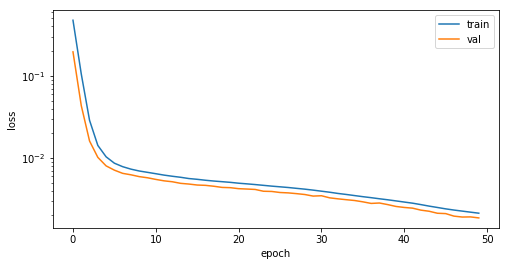

<Figure size 720x432 with 0 Axes>

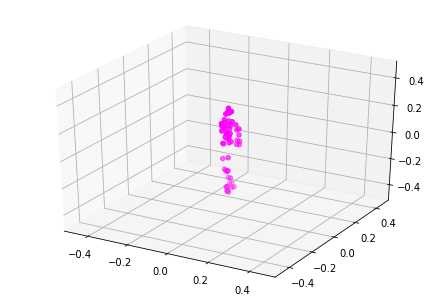

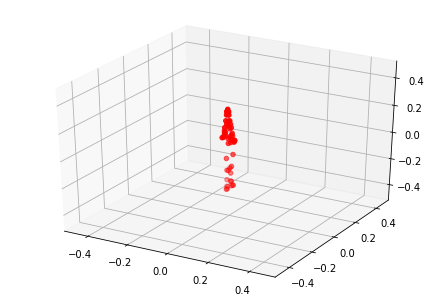

In [18]:
# plot losses and some example auto-encoded poses from the validation set
plt.figure(figsize=(8,4))
plt.plot(losses, label='train')
plt.plot(val_losses, label='val')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

n_sample = 1
itest = np.random.randint(0,X_test.shape[1],n_sample)
print("Using frame # {}".format(itest))
xtest = X_test.transpose((1,0,2))[itest]
ytest = auto.predict(xtest)
for i in range(n_sample):
    fig = plt.figure(figsize=(10,6))
    plt.suptitle("Validation frame %d"% itest[i])
    plot_pose(xtest[i]-xtest[i].mean(axis=0), center=True, colors='magenta')
    plot_pose(ytest[i]-ytest[i].mean(axis=0), center=True, colors='red')